#Case Study: Semantic Segmentation of Geospatial Imagery Using SAM and GeoAI
Semantic segmentation is the task of classifying each pixel in an image into a predefined class. It is widely used in remote sensing for applications like land cover mapping, urban analysis, disaster monitoring, and infrastructure detection.

In this case study, we demonstrate the use of the Segment Anything Model (SAM) — a cutting-edge vision transformer model by Meta AI — integrated within the GeoAI framework, to automatically detect and segment objects in a georeferenced satellite image.

##1. Install Required Library
We install the geoai-py library which provides tools for segmentation, downloading data, visualizing rasters and vectors, and converting between formats.

In [2]:
%pip install geoai-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.1/186.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.3/90.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.1/568.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/2

## 2. Import Necessary Modules

In [3]:
import geoai
from geoai.sam import SamGeo

##3. Download Sample Data
A high-resolution urban image is used from Davis, California.

In [4]:
url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/sam_demo_image.tif"
image = geoai.download_file(url)

##4. Visualize Input Image
Check what the image looks like before segmentation

In [5]:
geoai.view_raster(url)

##5. Initialize the Segment Anything Model
We initialize SAM in automatic mode. This enables detection of objects across the entire image without needing manual prompts.

In [6]:
sam = SamGeo(model="facebook/sam-vit-huge", automatic=True)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


##6. Generate Semantic Masks
The model runs and detects all meaningful objects, producing a .tif file of segmented masks.

In [7]:
sam.generate(source=image, output="masks.tif", foreground=True)

##7. Visualize Masks
You can visualize the output masks using:

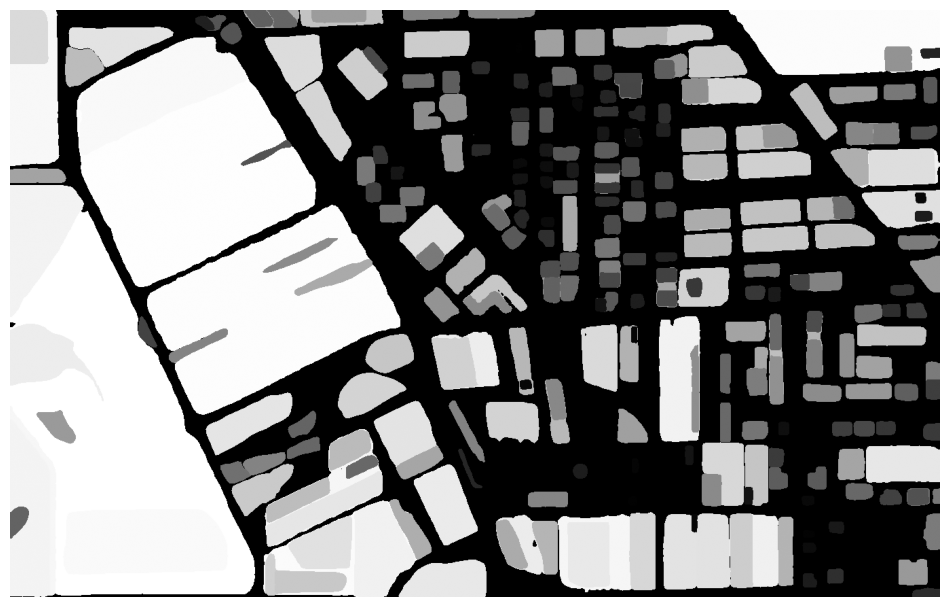

In [8]:
sam.show_masks()

##Overlay with transparency:

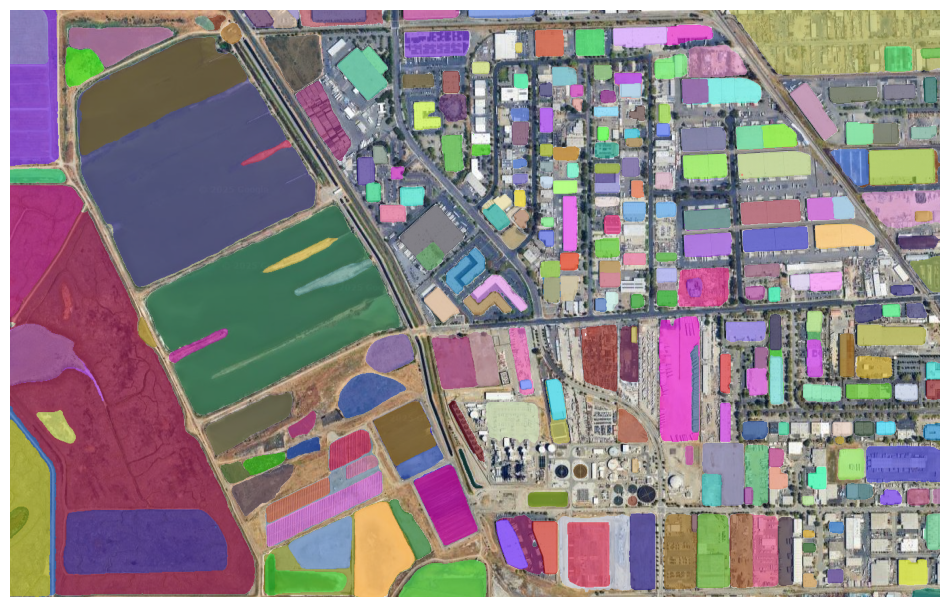

In [9]:
sam.show_anns(alpha=0.6)

#Insights and Interpretation
1. The SAM model segments visible features like buildings, vegetation patches, roads, and water bodies.
2. By generating masks automatically, we avoid the need for hand-labeling or training on local data.
3. The resulting masks can be used to generate training data, compute area statistics, or monitor urban change.


#Area statistics

Processing 1233 features...


Converting features: 100%|██████████| 1233/1233 [00:22<00:00, 54.92shape/s]


Saving to segmented_polygons.geojson...
Done!


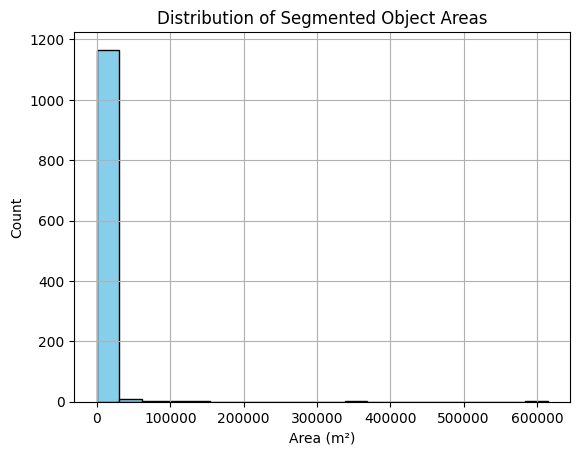

Summary Statistics (Area in m²):
count      1185.000000
mean       3602.020248
std       24563.758768
min           5.707042
25%           5.707042
50%          11.414042
75%         205.453496
max      614899.486685
Name: area_m2, dtype: float64

🧮 Total Detected Area: 4268393.99 m²


In [10]:
import geoai
import geopandas as gpd
import matplotlib.pyplot as plt
#Convert Masks to Vector Polygons
vector_path = "segmented_polygons.geojson"

gdf = geoai.orthogonalize(
    input_path="masks.tif",  # Replace with your actual mask path
    output_path=vector_path,
    epsilon=0.2  # Smoothing parameter
)

#Add Area and Shape Metrics
gdf = geoai.add_geometric_properties(gdf)

#Visualize Area Distribution
gdf["area_m2"].hist(bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of Segmented Object Areas")
plt.xlabel("Area (m²)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

#Summary Statistics
print("Summary Statistics (Area in m²):")
print(gdf["area_m2"].describe())

total_area = gdf["area_m2"].sum()
print(f"\n🧮 Total Detected Area: {total_area:.2f} m²")

#export your GeoDataFrame to a Shapefile
gdf.to_file("segmented_objects.shp", driver="ESRI Shapefile")


###This case study shows how powerful models like SAM can be integrated with spatial workflows using GeoAI, enabling efficient, scalable, and accurate semantic segmentation in remote sensing.


---


#Applications
1. Urban Planning: Automatically map buildings, roads, parks.
2. Disaster Management: Identify damaged areas post-flood or fire.
3. Agriculture: Detect crop fields, boundaries, irrigation zones.
4. Infrastructure Monitoring: Detect solar panels, rooftops, construction zones.